# Notebook to match Jow ingredients with Agribalyse ingredients and extract the corresponding scores

**Input data:**  
- **JOW data** (scrapped by Eliott): "../data/Recipes/recipes_jow.json" 
- **Agribalyse data** (downloaded on https://doc.agribalyse.fr/documentation/acces-donnees):   
"../data/Agribalyse/AGRIBALYSE3.1_produits alimentaires_2.xlsm" (industrials products after transformation, transport, packaging, ...)
    
**Output :** file 'Jow_Agribalyse_ingredients_scores.xlsx' with 469 JOW ingredients (including 27 with no match, those ingredients are associated to their corresponding Agribalyse categories)

**Some general comments :**
- For simplicity, we decide to characterize each Agribalyse ingredient (identified with its 'Nom produit' A1, A2, A3) by its 'Nom produit simple' A1 (i.e. by omitting informations after the first comma)  
- Jow ingredients are extracted from Jow recipes by ignoring informations in parenthesis
- Meaningless Jow ingredients are removed, e.g. "Pics à brochette", "Papier cuisson", "1/10 bou.", ...
- Each Jow ingredient is associated with one or several Agribalyse ingredients characterized by their 'Nom produit simple' (e.g. the Jow ingredient "Boeuf" is associated to a collection of Agribalyse ingredients with 'Nom produit simple' = 'Boeuf)
- Score calculation step: for a given Jow ingredient and a given type of score (eg the carbon footprint), we calculate the average value of this score on the different Agribalyse ingredients (identified by their 'Nom produit' or 'AGB code') matched with this Jow ingredient. To keep easy access to the list of Agribalyse ingredients used for calculated the mean for each ingredient, we add the column 'List of AGB codes' in the output file
- Jow ingredients that could not be directly matched with at least one Agribalyse ingredient are identified by the value 'no match' in the column 'AGB ingredients (simple, fr)'. Their scores are computed by calcuting the mean score of the corresponding general ingredient category (e.g. "fromages" for "Ricotta").

**Some technical comments :**
- The association between Jow and Agribalyse ingredients is done through the ingredient names in french (contrary to Eliott who translated Jow ingredients in english and did the matching in english). In the end, it is not clear to me which approach is the best. I chose to work in french: 1) to avoid the translation step, 2) to check more easily the results (since it is harder for me to identify wrong ingredient matching in english)
- **The matching process should be improved.** For now, it is done:
    - by ignoring at the first stage the Agribalyse ingredients from the category 'entrées et plats composés' (otherwise, we get wrong matching, e.g. "Lasagnes" which designates pasta in Jow is matched with "Lasagnes" which designates the meal in Agribalyse)
    - by using fuzzywuzzy with a high threshold value to avoid mistakes in matching (but a lot of ingredients are not matched at all)
    - by using some 'home-made' automatic matching rules (see below) 
    - then by doing a lot lot lot of corrections by hand (due to fuzzywuzzy mistakes, other automatic mistakes, or no automatic matching)
    - at the very end, we match by hand the remaining Jow ingredients with Agribalyse ingredients from the category 'entrées et plats composés' if appropriate
    - there remains 37 Jow ingredients which cannot be matched with Agribalyse ingredients (even manually, or at least this requires discussion)


In [1]:
import pandas as pd
import numpy as np
import re

### Load Agribalyse data 

In [2]:
data_AGB = pd.read_excel("../data/Agribalyse/AGRIBALYSE3.1_produits alimentaires_2.xlsm", \
                                     sheet_name = 'Synthese', skiprows = 1, header = [0 ,1])

In [3]:
data_AGB.head(2)

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,Unnamed: 4_level_0,Unnamed: 5_level_0,Unnamed: 6_level_0,Unnamed: 7_level_0,Unnamed: 8_level_0,Unnamed: 9_level_0,...,Effets toxicologiques sur la santé humaine : substances cancérogènes,Acidification terrestre et eaux douces,Eutrophisation eaux douces,Eutrophisation marine,Eutrophisation terrestre,Écotoxicité pour écosystèmes aquatiques d'eau douce,Utilisation du sol,Épuisement des ressources eau,Épuisement des ressources énergétiques,Épuisement des ressources minéraux
,Code\nAGB,Code\nCIQUAL,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,LCI Name,code saison (0 : hors saison ; 1 : de saison ; 2 : mix de consommation FR),code avion (1 : par avion),Livraison,Matériau d'emballage,...,CTUh/kg de produit,mol H+ eq/kg de produit,kg P eq/kg de produit,kg N eq/kg de produit,mol N eq/kg de produit,CTUe/kg de produit,Pt/kg de produit,m3 depriv./kg de produit,MJ/kg de produit,kg Sb eq/kg de produit
0,11084,11084,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.01328,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088
1,11023,11023,aides culinaires et ingrédients divers,herbes,"Ail séché, poudre","Garlic, powder, dried",2,0,Ambiant (long),Verre,...,4.662163e-10,0.006222,0.000124,0.00232,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007


Rename the columns

In [4]:
# Flatten the MultiIndex into a Single Index
data_AGB.columns = ['_'.join(col) if type(col) is tuple else col for col in data_AGB.columns.values]

old_col_names = data_AGB.columns

new_col_names = ['Code AGB',
                 'Code CIQUAL',
                 'Groupe',
                 'Sous-groupe',
                 'Nom produit',    # Nom du Produit en Français (traduction approximative GoogleTranslate)
                 'LCI name', 
                 'Code saison',
                 'Code avion',
                 'Livraison',
                 'Emballage',
                 'Préparation',
                 'DQR', 
                 'PEF',            # Score unique EF3.1 (mPt/kg)
                 'CO2',            # Changement climatique (kg CO2 eq/kg)
                 'Ozone_1',        # Appauvrissement de la couche d'ozone (kg CFC11 eq/kg)
                 'Rad',            # Rayonnements ionisants (kBq U-235 eq/kg)
                 'Ozone_2',        # Formation photochimique d'ozone (kg NMVOC eq/kg)
                 'Particules',     # Particules (disease inc./kg)
                 'Toxic_1',        # Effets toxicologiques sur la santé humaine : substances non-cancérogènes (CTUh/kg)
                 'Toxic_2',        # Effets toxicologiques sur la santé humaine : substances cancérogènes (CTUh/kg)
                 'Acid',           # Acidification terrestre et eaux douces (mol H+ eq/kg)
                 'Eutro_1',        # Eutrophisation eaux douces (kg P eq/kg)
                 'Eutro_2',        # Eutrophisation marine (kg N eq/kg)
                 'Eutro_3',        # Eutrophisation terrestre (mol N eq/kg)
                 'Ecotoxic',       # Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg)
                 'Sol',            # Utilisation du sol (Pt/kg)
                 'Ressource_1',    # Épuisement des ressources eau (m3 depriv./kg)
                 'Ressource_2',    # Épuisement des ressources énergétiques (MJ/kg)
                 'Ressource_3'     # Épuisement des ressources minéraux (kg Sb eq/kg)
                ]


dict_col_rename = {}
for i in range(len(old_col_names)):
    dict_col_rename[old_col_names[i]] = new_col_names[i]
    
data_AGB = data_AGB.rename(columns = dict_col_rename)

In [5]:
data_AGB.head(2)

,Code AGB,Code CIQUAL,Groupe,Sous-groupe,Nom produit,LCI name,Code saison,Code avion,Livraison,Emballage,...,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_3,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,11084,11084,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.01328,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088
1,11023,11023,aides culinaires et ingrédients divers,herbes,"Ail séché, poudre","Garlic, powder, dried",2,0,Ambiant (long),Verre,...,4.662163e-10,0.006222,0.000124,0.00232,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007


In [6]:
print("Total number of ingredients =", data_AGB.shape[0])

Total number of ingredients = 2517


We add a column "Nom produit simple" with a simplified "Nom produit" : A1, A2, A3, ... -> A1

In [7]:
data_AGB['Nom produit simple'] = data_AGB['Nom produit'].apply(lambda x: x.split(',')[0])

We remove ligatures, e.g. Bœuf -> Boeuf

In [8]:
REGEX_REPLACEMENTS = [(r"\u0153", "oe"), \
                      (r"\u0152", "Oe")]

def remove_ligatures(transcript):
    for old, new in REGEX_REPLACEMENTS:
        transcript = re.sub(old, new, transcript, flags=re.IGNORECASE)
    return transcript

#data_AGB['Nom produit simple'] = data_AGB['Nom produit simple'].apply(lambda s: remove_ligatures(str(s)))

for col in data_AGB.columns:
    if pd.api.types.is_object_dtype(data_AGB[col].dtypes):   # if the column type is object
        data_AGB[col] = data_AGB[col].apply(lambda s: remove_ligatures(str(s)))

In [9]:
data_AGB.head(2)

,Code AGB,Code CIQUAL,Groupe,Sous-groupe,Nom produit,LCI name,Code saison,Code avion,Livraison,Emballage,...,Acid,Eutro_1,Eutro_2,Eutro_3,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3,Nom produit simple
0,11084,11084,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,0.099733,0.001868,0.01328,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088,Agar (algue)
1,11023,11023,aides culinaires et ingrédients divers,herbes,"Ail séché, poudre","Garlic, powder, dried",2,0,Ambiant (long),Verre,...,0.006222,0.000124,0.00232,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007,Ail séché


In [10]:
print("Number of different ingredients in 'Nom produit simple' = ", data_AGB['Nom produit simple'].unique().shape[0])

Number of different ingredients in 'Nom produit simple' =  1696


**Note**  
For some products, it is not fully meaningful to simplify the product name "A1, A2, A3, ..." by its first noun "A1" before the first comma and take the score mean **since there might exist big variations between entries with same A1 but different A2, A3, ... However, we will follow this approach for simplicity reasons.** The best approach would be probably to identify the problematic ingredients and:
- either store the corresponding error bars 
- or keep the full name A1, A2, A3 (but probably there is no hope to reach this precision level with restaurant menus)

### Let's prepare now the dataframe for JOW ingredients

In [11]:
jow_data = pd.read_json('../data/Recipes/recipes_jow.json')
jow_data = jow_data.transpose()
pd.set_option('display.max_colwidth', None)
jow_data.head()

,cuisson,ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]"
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]"
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]"
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]"


Let's remove ligatures, e.g. Bœuf -> Boeuf

In [12]:
jow_data['ingredients'] = jow_data['ingredients'].apply(lambda x: [[remove_ligatures(str(s)) for s in l] for l in x ])
jow_data.head()

,cuisson,ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Boeuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]"
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]"
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]"
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, oeuf], [40 g, Parmesan (morceaux)]]"


Extract the list of ingredients (by ignoring infos in parenthesis)

In [13]:
jow_dict = jow_data.to_dict('index')

# Keeping only ingredients
jow_ingredients = []

for key in jow_dict:
    for i in jow_dict[key]["ingredients"]:
        if len(i)>1:
            jow_ingredients.append(i[-1])
        #else:
        #    print(i)

jow_ingredients = list(dict.fromkeys(jow_ingredients))   # to remove doublons 
# remove informations in parenthesis
jow_ingredients = [re.sub("[\(\[].*?[\)\]]", "", x) for x in jow_ingredients]  
# remove blank at the end of the string that remained when parenthesis have been removed
jow_ingredients = [x[:-1] if x[-1]==" " else x for x in jow_ingredients]       
jow_ingredients = list(dict.fromkeys(jow_ingredients))

print("Number of JOW ingredients (omitting infos in parenthesis) = ", len(jow_ingredients))

Number of JOW ingredients (omitting infos in parenthesis) =  483


In [14]:
df_ingredients = pd.DataFrame(jow_ingredients, columns=["JOW ingredients (fr)"])
df_ingredients.head()

,JOW ingredients (fr)
0,Boeuf
1,Emmental
2,Sauce Teriyaki
3,Riz
4,Pics à brochette


### Match the two bdds ie match Jow ingredients with Agribalyse ingredients

Define rules to do the matching. Most important part, should be improved!

In [15]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
#import nltk
#from nltk.stem.snowball import FrenchStemmer
#stemmer = FrenchStemmer()

# Very simple and bad function to singularize
# Only works when the plural comes with a "s" e.g. "champignons", not with a "x"
# I tried to find best solutions with re or nltk but with no success
# Should be improved
def singularize(word):
    if word[-1]=='s':
        return word[:-1]
    else:
        return word

# Most important function written quickly -> should be improved!
def most_similar_ingredient(string, list_ingredients, tresh):
    
    list_ingredients = list(set(list_ingredients))
    s = string.lower()
    
    scores = [fuzz.token_sort_ratio(s, ingredient) for ingredient in list_ingredients]
    # Note that the case where several ingredients have the same score is not included
    idx_score, score = max(list(enumerate(scores)), key=lambda x: x[1])  # max of scores with its index idx_score
    
    if score > tresh:
        res =  list_ingredients[idx_score] 
        
    else: 
        # Match if the first word of jow and of agribalyse are equal (up to a final "s")
        res_3 = []
        s0 = s.split(" ")[0]    # first word of s

        for ingredient in list_ingredients:
            ingredient0 = ingredient.lower().split(" ")[0]   # first word of ingredient
            if singularize(s0)==singularize(ingredient0):
                res_3.append(ingredient) 

        if len(res_3)!=0:
            res = res_3 if len(res_3)>1 else res_3[0]
            
        else:
            res_2 = []

            # List ingredients of list_ingredients which contain s or singularize(s)
            for ingredient in list_ingredients:
                if s in ingredient.lower() or singularize(s) in ingredient.lower():
                    res_2.append(ingredient) 

            if len(res_2)!=0:
                '''
                # If this list is not empty, choose the one which is the closest to s in terms of fuzzywuzzy
                scores = [fuzz.token_sort_ratio(s, ingredient) for ingredient in res_2]
                # Note that the case where several ingredients have the same score is not included
                idx_score, score = max(list(enumerate(scores)), key=lambda x: x[1])  
                res =  res_2[idx_score] 
                '''
                res = res_2 if len(res_2)>1 else res_2[0]
            else:
                res = "no match"
               
    return res

**We remove all "entrées et plats composés" from data_AGB** because we only want ingredients to do the matching with jow ingredients.   
If we don't do that, we have some problems with e.g. "Lasagnes" from Jow (pasta, not stuffed) which is associated with "Lasagnes" in Agribalyse (pasta stuffed with meat, vegetables, or whatever).

In [16]:
data_AGB_ingredients = data_AGB.copy()
data_AGB_ingredients = data_AGB_ingredients.drop(data_AGB_ingredients[data_AGB_ingredients['Groupe']=='entrées et plats composés'].index)

In [17]:
print("Total number of agribalyse ingredients = ", data_AGB.shape[0])
print("Number of remaining ingredients = ", data_AGB_ingredients.shape[0])

Total number of agribalyse ingredients =  2517
Number of remaining ingredients =  2225


Let's now do the automatic matching!

In [18]:
# Here it seems to be good to take a large fuzzywuzzy threshold value 'tresh' (75 or 80) to avoid mistakes at this step
# and then treat the other cases with the other simpler rules in the function most_similar_ingredients
# This is fastidious but should minimize errors
# OF COURSE THIS STEP IS CENTRAL AND SHOULD BE IMPROVED
df_ingredients["AGB ingredients (fr)"] = df_ingredients["JOW ingredients (fr)"].apply(lambda x: \
                                                most_similar_ingredient(x, data_AGB_ingredients["Nom produit simple"], \
                                                tresh=75))

In [19]:
df_ingredients.head(10)

,JOW ingredients (fr),AGB ingredients (fr)
0,Boeuf,Boeuf
1,Emmental,"[Emmental ou emmenthal, Emmental ou emmenthal râpé]"
2,Sauce Teriyaki,"[Sauce tomate aux olives, Sauce au chocolat, Sauce carbonara, Sauce pesto rosso, Sauce au curry, Sauce indienne type tandoori ou tikka masala, Sauce à la crème aux herbes, Sauce rouille, Sauce kebab, Sauce grand veneur, Sauce au vin rouge, Sauce aïoli, Sauce madère, Sauce tomate aux oignons, Sauce végétale type bolognaise, Sauce burger, Sauce soja, Sauce au poivre vert, Sauce bourguignonne, Sauce hollandaise, Sauce chasseur, Sauce au fromage pour risotto ou pâtes, Sauce au beurre, Sauce pesto, Sauce barbecue, Sauce à l'échalote à la crème, Sauce moutarde, Sauce au poivre, Sauce vinaigrette (50 à 75% d'huile), Sauce crudités ou Sauce salade, Sauce Nuoc Mâm ou Sauce au poisson, Sauce au beurre blanc, Sauce aux champignons et à la crème, Sauce béarnaise, Sauce basquaise ou Sauce aux poivrons, Sauce américaine, Sauce tartare, Sauce au roquefort, Sauce aigre douce, Sauce tomate à la viande ou Sauce bolognaise, Sauce aux champignons, Sauce tomate aux petits légumes, Sauce tomate au fromage, Sauce à la crème, Sauce tomate aux champignons, Sauce béchamel, Sauce armoricaine, Sauce à la crème aux épices, Sauce au yaourt]"
3,Riz,Riz
4,Pics à brochette,Brochette de porc
5,Gnocchi,"[Gnocchi à la pomme de terre, Gnocchi à la semoule]"
6,Epinard,Épinard
7,Gorgonzola,Gorgonzola
8,Crème liquide,"[Crème de marrons vanillée, Crème dessert à la vanille, Crème de cassis, Crème aux oeufs (petit pot de crème chocolat, Crème de marrons, Crème brûlée, Crème pâtissière, Crème anglaise, Crème dessert au caramel, Crème chantilly, Crème dessert au café, Crème de lait, Crème dessert, Crème caramel, Crème dessert au chocolat]"
9,Lentilles corail,Lentille corail


**There remains a lot of mistakes ... let's correct them by hand, be patient ...**

Let's first remove jow ingredients that are meaningless 

In [20]:
# Select rows classified with "no match"
df_nomatch = df_ingredients[df_ingredients['AGB ingredients (fr)']=='no match']

# Store the ones including numbers
jow_ingredients_to_drop = df_nomatch["JOW ingredients (fr)"][df_nomatch["JOW ingredients (fr)"]\
                                                             .str.contains(re.compile("[0-9]"))].tolist()

# Identify "manually" jow ingredients that are meaningless 
jow_ingredients_nosense = ['Papier cuisson', 'Pics à brochette']

# Remove all them from the list of jow ingredients
jow_ingredients_to_drop = jow_ingredients_to_drop + jow_ingredients_nosense
print("Number of meaningless Jow ingredients to be removed = ", len(jow_ingredients_to_drop))
print("Meaningless Jow ingredients to be removed : \n", jow_ingredients_to_drop)

for ingredient in jow_ingredients_to_drop:
    df_ingredients = df_ingredients.drop(df_ingredients[df_ingredients["JOW ingredients (fr)"]==ingredient].index)

Number of meaningless Jow ingredients to be removed =  14
Meaningless Jow ingredients to be removed : 
 ['1/10 bou.', '1/5 bou.', '1/50 bou.', '6 pinc.', '1 càc', '1/4', '3 pinc.', '2 càs', '1 cm', '1/20 bou.', '1 càs', '1/2 càc', 'Papier cuisson', 'Pics à brochette']


In [21]:
print("Number of Jow ingredients after pre-processing = ", df_ingredients.shape[0])

Number of Jow ingredients after pre-processing =  469


The automatic matching has generated a lot of "no match". Let's look at them and correct them if possible. Remember that the matching is done by considering the column 'Nom produit simple' of Agribalyse data.

In [22]:
df_nomatch = df_ingredients[df_ingredients['AGB ingredients (fr)']=='no match']
df_nomatch.head(10)

,JOW ingredients (fr),AGB ingredients (fr)
13,Lasagnes,no match
40,Cornichon,no match
58,Chapelure,no match
67,Graines de sésame,no match
74,Ricotta,no match
76,Burrata,no match
93,ravioles au fromage,no match
133,Udon,no match
143,Gaspacho,no match
144,Bouquet garni,no match


In [23]:
for ingredient in ['Martini Fiero', 'Apérol', 'Lillet blanc']: 
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==ingredient, 'AGB ingredients (fr)']='Apéritif à base de vin ou vermouth'

for ingredient in ['Grand Marnier', 'Cointreau', 'Amaretto']: 
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==ingredient, 'AGB ingredients (fr)']='Liqueur'
    
for ingredient in ['Tequila', 'Cachaça']: 
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==ingredient, 'AGB ingredients (fr)']='Eau de vie'
    
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Prosecco', 'AGB ingredients (fr)']='Vin blanc mousseux'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Ginger beer', 'AGB ingredients (fr)']='Bière faiblement alcoolisée (3° alcool)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Cognac', 'AGB ingredients (fr)']='Eau de vie de vin'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Graines de courge', 'AGB ingredients (fr)']='Cucurbitacées'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Graines de Chia', 'AGB ingredients (fr)']='Chia'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Graines de sésame', 'AGB ingredients (fr)']='Sésame'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Tahini', 'AGB ingredients (fr)']='Tahin ou Purée de sésame'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Knack', 'AGB ingredients (fr)']='Saucisse de Strasbourg ou Knack'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Gigot d'agneau", 'AGB ingredients (fr)']='Agneau'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Vache qui rit", 'AGB ingredients (fr)']='Fromage fondu en portions ou en cubes environ 20% MG'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Kiri", 'AGB ingredients (fr)']='Fromage fondu en portions ou en cubes environ 20% MG'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Émincé végétal", 'AGB ingredients (fr)']=[["Boulette végétale au soja et/ou blé", \
                                                                                                           "Bouchées ou émincé au soja et blé (ne convient pas aux véganes ou végétaliens)"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Steak végétal", 'AGB ingredients (fr)']=[["Escalope végétale ou steak à base de soja", \
                                                                                                           'Galette ou pavé au blé et soja (convient aux véganes ou végétaliens)']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pousses de soja", 'AGB ingredients (fr)']='Haricot mungo germé ou pousse de "soja"'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Maïzena", 'AGB ingredients (fr)']='Farine de maïs'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mirabelle", 'AGB ingredients (fr)']='Prune'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Algues nori", 'AGB ingredients (fr)']='Nori (Porphyra sp.)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Taco kit", 'AGB ingredients (fr)']='Tortilla souple (à garnir)'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Crousti' taco kit", 'AGB ingredients (fr)']='Tortilla souple (à garnir)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Gros sel", 'AGB ingredients (fr)']='Sel blanc alimentaire'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Udon", 'AGB ingredients (fr)']=[['Nouilles asiatiques cuites', \
                                                                                                 'Nouilles asiatiques aromatisées']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Épices orientales", 'AGB ingredients (fr)']='Quatre épices'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Épices tandoori", 'AGB ingredients (fr)']='Quatre épices'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Ras el hanout", 'AGB ingredients (fr)']='Quatre épices'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Garam masala", 'AGB ingredients (fr)']='Quatre épices'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Yellow mustard", 'AGB ingredients (fr)']=[['Moutarde', \
                                                                                                            'Sauce moutarde']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Skyr", 'AGB ingredients (fr)']='Yaourt'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Cabécou", 'AGB ingredients (fr)']='Fromage de chèvre frais'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pecorino Romano", 'AGB ingredients (fr)']='Fromage de brebis à pâte pressée'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Corn flakes", 'AGB ingredients (fr)']=[['Pétales de maïs natures (non enrichis en vitamines et minéraux)', \
                                                                                                        'Pétales de maïs glacés au sucre']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Demi-baguette", 'AGB ingredients (fr)']='Pain'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Caramel', 'AGB ingredients (fr)']='Bonbon au caramel'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Cracker', 'AGB ingredients (fr)']='Biscuit apéritif'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Mini-toast', 'AGB ingredients (fr)']='Pain grillé'




In [24]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Sauce piment', 'AGB ingredients (fr)']='Harissa (sauce condimentaire)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Kit fajitas', 'AGB ingredients (fr)']='Tortilla souple (à garnir)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Raisins secs', 'AGB ingredients (fr)']='Raisin'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Palet breton', 'AGB ingredients (fr)']='Biscuit sec au beurre'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Marron glacé', 'AGB ingredients (fr)']='Châtaigne ou Marron'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Crozets', 'AGB ingredients (fr)']=[['Pâtes sèches standard', 'Pâtes sèches']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Nem', 'AGB ingredients (fr)']='Nem ou Pâté impérial'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Citron confit", 'AGB ingredients (fr)']='Citron'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Aligot", 'AGB ingredients (fr)']='Aligot (purée de pomme de terre à la tomme fraîche)'


The automatic matching process sometimes associates a single jow ingredient to a list of several possible agribalyse ingredients (with simplified 'Nom Produit Simple'). This is definitely not precise enough but allows us to get a pre-selection of possible agribalyse ingredients for a given jow ingredient. Let's see now if we can refine the selection by hand.

In [25]:
df_ingredients[df_ingredients['AGB ingredients (fr)'].apply(lambda x: isinstance(x, list))].head()

,JOW ingredients (fr),AGB ingredients (fr)
1,Emmental,"[Emmental ou emmenthal, Emmental ou emmenthal râpé]"
2,Sauce Teriyaki,"[Sauce tomate aux olives, Sauce au chocolat, Sauce carbonara, Sauce pesto rosso, Sauce au curry, Sauce indienne type tandoori ou tikka masala, Sauce à la crème aux herbes, Sauce rouille, Sauce kebab, Sauce grand veneur, Sauce au vin rouge, Sauce aïoli, Sauce madère, Sauce tomate aux oignons, Sauce végétale type bolognaise, Sauce burger, Sauce soja, Sauce au poivre vert, Sauce bourguignonne, Sauce hollandaise, Sauce chasseur, Sauce au fromage pour risotto ou pâtes, Sauce au beurre, Sauce pesto, Sauce barbecue, Sauce à l'échalote à la crème, Sauce moutarde, Sauce au poivre, Sauce vinaigrette (50 à 75% d'huile), Sauce crudités ou Sauce salade, Sauce Nuoc Mâm ou Sauce au poisson, Sauce au beurre blanc, Sauce aux champignons et à la crème, Sauce béarnaise, Sauce basquaise ou Sauce aux poivrons, Sauce américaine, Sauce tartare, Sauce au roquefort, Sauce aigre douce, Sauce tomate à la viande ou Sauce bolognaise, Sauce aux champignons, Sauce tomate aux petits légumes, Sauce tomate au fromage, Sauce à la crème, Sauce tomate aux champignons, Sauce béchamel, Sauce armoricaine, Sauce à la crème aux épices, Sauce au yaourt]"
5,Gnocchi,"[Gnocchi à la pomme de terre, Gnocchi à la semoule]"
8,Crème liquide,"[Crème de marrons vanillée, Crème dessert à la vanille, Crème de cassis, Crème aux oeufs (petit pot de crème chocolat, Crème de marrons, Crème brûlée, Crème pâtissière, Crème anglaise, Crème dessert au caramel, Crème chantilly, Crème dessert au café, Crème de lait, Crème dessert, Crème caramel, Crème dessert au chocolat]"
11,Lait de coco,"[Lait concentré sucré, Lait concentré non sucré, Lait gélifié aromatisé, Lait en poudre, Lait de coco ou Crème de coco, Lait de croissance infantile, Lait 1er âge, Lait de brebis, Lait 2e âge, Lait fermenté à boire, Lait demi-écrémé, Lait écrémé, Lait fermenté ou spécialité laitière type yaourt, Lait entier, Lait de chèvre, Lait emprésuré aromatisé]"


In [26]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Sauce Teriyaki', 'AGB ingredients (fr)']='Sauce soja'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Crème liquide', 'AGB ingredients (fr)']='Crème de lait'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Crème fraîche épaisse', 'AGB ingredients (fr)']='Crème de lait'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Lait de coco', 'AGB ingredients (fr)']='Lait de coco ou Crème de coco'

for pasta in ['Pâtes', 'Lasagnes', 'Ravioli']:
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==pasta, 'AGB ingredients (fr)']=[['Pâtes fraîches', \
                                                                                                  'Pâtes sèches standard', \
                                                                                                  'Pâtes sèches']]
    
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Champignons de Paris', 'AGB ingredients (fr)']='Champignon'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Jambon blanc', 'AGB ingredients (fr)']='Jambon cuit'

for beurre in ['Beurre demi-sel', 'Beurre']:
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==beurre, 'AGB ingredients (fr)']=[['Beurre à 60-62% MG', \
                                                                                                    'Beurre à 80% MG', \
                                                                                                    'Beurre à 82% MG', \
                                                                                                   'Beurre à 39-41% MG']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Farine de blé', 'AGB ingredients (fr)']=[['Farine de blé tendre ou froment T150', \
                                                                                                           'Farine de blé tendre ou froment avec levure incorporée', \
                                                                                                           'Farine de blé tendre ou froment T80', 
                                                                                                          'Farine de blé tendre ou froment T45 (pour pâtisserie)',
                                                                                                          'Farine de blé tendre ou froment T55 (pour pains)', 
                                                                                                          'Farine de blé tendre ou froment T65']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Citron jaune', 'AGB ingredients (fr)']=[['Citron', \
                                                                                                          'Citron ou Lime']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Galette bretonne', 'AGB ingredients (fr)']='Galette de sarrasin'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Fromage râpé', 'AGB ingredients (fr)']='Emmental ou emmenthal râpé'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Salade', 'AGB ingredients (fr)']=[['Salade verte', \
                                                                                                   'Salade ou chicorée frisée']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Pain de campagne', 'AGB ingredients (fr)']=[['Pain de campagne maison (avec farine pour machine à pain)', \
                                                                                                               'Pain']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Fromage frais', 'AGB ingredients (fr)']=[['Fromage de chèvre frais', \
                                                                                                           'Fromage frais type petit suisse', \
                                                                                                          'Mozzarella au lait de vache']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Confiture de cerise', 'AGB ingredients (fr)']='Confiture de cerise (extra ou classique)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Mélange céréales', 'AGB ingredients (fr)']='Mélange de céréales et légumineuses'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Sauce tikka masala', 'AGB ingredients (fr)']='Sauce indienne type tandoori ou tikka masala'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Sauce Curry Korma', 'AGB ingredients (fr)']='Sauce indienne type tandoori ou tikka masala'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Marrons', 'AGB ingredients (fr)']='Châtaigne ou Marron'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Confits d'oignons", 'AGB ingredients (fr)']='Oignon'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sauce Arrabbiata", 'AGB ingredients (fr)']='Sauce basquaise ou Sauce aux poivrons'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Chocolat à cuire", 'AGB ingredients (fr)']=[['Chocolat noir à moins de 70% de cacao', \
                                                                                                              'Chocolat noir à 40% de cacao minimum', \
                                                                                                              'Chocolat noir à 70% cacao minimum', \
                                                                                                             'Chocolat noir sans sucres ajoutés']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pomme Rouge", 'AGB ingredients (fr)']='Pomme'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Yaourt nature", 'AGB ingredients (fr)']='Yaourt'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Vinaigre de vin rouge", 'AGB ingredients (fr)']='Vinaigre'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Vinaigre de vin blanc", 'AGB ingredients (fr)']='Vinaigre'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Vinaigre de Xérès", 'AGB ingredients (fr)']='Vinaigre'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Noix de Saint-Jacques", 'AGB ingredients (fr)']='Coquille Saint-Jacques'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mélange épices mexicaines", 'AGB ingredients (fr)']='Quatre épices'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Chips de tortillas", 'AGB ingredients (fr)']='Chips de maïs ou tortilla chips'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Haricots blancs nature", 'AGB ingredients (fr)']='Haricot blanc'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pâte miso", 'AGB ingredients (fr)']='Miso'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pâte à tartiner", 'AGB ingredients (fr)']='Pâte à tartiner chocolat et noisette'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Confiture de myrtilles", 'AGB ingredients (fr)']='Confiture'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Compote rhubarbe", 'AGB ingredients (fr)']='Compote'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Compote abricot", 'AGB ingredients (fr)']='Compote'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pain burger", 'AGB ingredients (fr)']='Pain pour hamburger ou hot dog (bun)'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Crème liquide 30%", 'AGB ingredients (fr)']='Crème de lait'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Petit suisse", 'AGB ingredients (fr)']='Fromage frais type petit suisse'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Biscuit cuiller", 'AGB ingredients (fr)']='Biscuit sec aux oeufs à la cuillère (cuiller) ou Boudoir'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mélange pour pâtes", 'AGB ingredients (fr)']='Sauce au fromage pour risotto ou pâtes'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sauce nuoc-mâm", 'AGB ingredients (fr)']='Sauce Nuoc Mâm ou Sauce au poisson'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Eau gazeuse", 'AGB ingredients (fr)']='Eau minérale Rozana'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Jus de cranberry", 'AGB ingredients (fr)']='Jus de fruits rouges'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Crème glacée Vanille", 'AGB ingredients (fr)']='Glace ou crème glacée'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Crème d'Isigny", 'AGB ingredients (fr)']='Crème de lait'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="oeufs de poisson", 'AGB ingredients (fr)']='Tarama'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fruit de la passion", 'AGB ingredients (fr)']='Fruit de la passion ou maracudja'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fromage fouetté", 'AGB ingredients (fr)']='Fromage frais type petit suisse'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fromage ail & fines herbes", 'AGB ingredients (fr)']='Spécialité fromagère non affinée à tartiner environ 30-40 % MG aromatisée (ex: ail et fines herbes)'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Boisson coco", 'AGB ingredients (fr)']='Boisson à la noix de coco'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Boisson végétale noisette", 'AGB ingredients (fr)']="Boisson à l'amande"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Julienne de légumes", 'AGB ingredients (fr)']="Julienne ou brunoise de légumes"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sirop de menthe", 'AGB ingredients (fr)']="Boisson préparée à partir de sirop à diluer type menthe"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sirop de sucre de canne", 'AGB ingredients (fr)']="Sirop à diluer"

Let's now have a final look at all entries and correct mistakes done by fuzzywuzzy matching.

Some Jow ingredients have been wrongly matched to Agribalyse ingredients while it seems there is no appropriate match for them. Let's correct it.

In [27]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Vinaigre de riz', 'AGB ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Pâte de curry', 'AGB ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Huile aromatisée à la truffe', 'AGB ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Yaourt végétal", 'AGB ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mélange curry de lentilles", 'AGB ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Olive noire", 'AGB ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fond de veau", 'AGB ingredients (fr)']="no match"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mascarpone", 'AGB ingredients (fr)']="no match"

Some Jow ingredients have been wrongly matched to Agribalyse ingredients, e.g. "Mangue" with "Langue" or "Lardons" with "Cardon". Let's correct it.

In [28]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Lardons", 'AGB ingredients (fr)']=[['Lardon nature', \
                                                                                                     'Lardon fumé']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Oignon jaune", 'AGB ingredients (fr)']="Oignon"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Oignon rouge", 'AGB ingredients (fr)']="Oignon"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Lait", 'AGB ingredients (fr)']=[["Lait demi-écrémé", \
                                                                                                 "Lait entier"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Rosette", 'AGB ingredients (fr)']="Rosette ou Fuseau"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Chèvre", 'AGB ingredients (fr)']=[["Rocamadour (fromage de chèvre)", \
                                                                                                "Fromage de chèvre lactique affiné"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Citron vert", 'AGB ingredients (fr)']="Citron vert ou Lime"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Polenta", 'AGB ingredients (fr)']="Polenta ou semoule de maïs"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mangue", 'AGB ingredients (fr)']=[["Mangue importée par avion", \
                                                                                                   "Mangue importée par bateau"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Semoule", 'AGB ingredients (fr)']=[["Couscous (semoule de blé dur roulée précuite à la vapeur)", \
                                                                                                    "Semoule de blé dur"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Graines de tournesol", 'AGB ingredients (fr)']="Tournesol"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Beurre de cacahuète", 'AGB ingredients (fr)']="Beurre de cacahuète ou Pâte d'arachide"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sauce tomate", 'AGB ingredients (fr)']=[["Sauce tomate aux petits légumes", \
                                                                                                         "Sauce tomate au fromage", \
                                                                                                         "Sauce tomate aux oignons"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Saucisse", 'AGB ingredients (fr)']=[["Saucisse de Francfort", \
                                                                                                     "Saucisse de Strasbourg ou Knack", \
                                                                                                     "Saucisse de Morteau", \
                                                                                                     "Saucisse de Toulouse"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Morilles", 'AGB ingredients (fr)']="Champignon"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Huile d'olive", 'AGB ingredients (fr)']="Huile d'olive vierge extra"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Tomate pelée", 'AGB ingredients (fr)']="Tomate"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Haricots", 'AGB ingredients (fr)']=[["Haricot vert", \
                                                                                                      "Haricot blanc", \
                                                                                                      "Haricot flageolet", \
                                                                                                      "Haricot rouge"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pain noir", 'AGB ingredients (fr)']="Pain complet ou intégral (à la farine T150)"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Poudre d'amande", 'AGB ingredients (fr)']="Amande"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Poudre de noisette", 'AGB ingredients (fr)']="Noisette"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Tomme", 'AGB ingredients (fr)']="Tomme ou tome"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Huile de coco", 'AGB ingredients (fr)']="Lait de coco ou Crème de coco"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Confiture de figues", 'AGB ingredients (fr)']="Confiture"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Thon au citron", 'AGB ingredients (fr)']="Thon"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fécule de pommes de terre", 'AGB ingredients (fr)']="Amidon de maïs ou fécule de maïs"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Boisson végétale", 'AGB ingredients (fr)']=[["Boisson à base d'avoine", \
                                                                                                             "Boisson à base de riz", \
                                                                                                             "Boisson à l'amande", \
                                                                                                             "Boisson au soja"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Grenadine", 'AGB ingredients (fr)']="Boisson préparée à partir de sirop à diluer type menthe"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sirop de pêche", 'AGB ingredients (fr)']="Boisson préparée à partir de sirop à diluer type menthe"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Filet de saumon", 'AGB ingredients (fr)']="Saumon"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Filet de poisson", 'AGB ingredients (fr)']=[["Saumon", \
                                                                                                              "Cabillaud"]]

**Open question : what should we do with entries like 'Nuggets' with "no match" for now but that could be matched with some "entrées et plats composés" of the Agribalyse Database (can be frozen food)?**  
Note that if we want to include e.g. 'Nuggets', it is not sufficient to truncate the ingredient name A1, A2, A3, ... as A1, since A1 here is 'Poulet.   
--> We choose to include a posteriori "entrées et plats composés" of the Agribalyse Database to perfect the matching.

In [29]:

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Bouillon de légumes", 'AGB ingredients (fr)']="Bouillon de légumes"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Bouillon de volaille", 'AGB ingredients (fr)']="Bouillon de volaille"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Falafel", 'AGB ingredients (fr)']="Falafel ou Boulette de pois-chiche et/ou fève"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Boulettes de viande", 'AGB ingredients (fr)']="Boulettes au boeuf"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Poêlée de légumes", 'AGB ingredients (fr)']="Poêlée de légumes assaisonnés grillée"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Poêlée champêtre", 'AGB ingredients (fr)']="Poêlée de légumes assaisonnés aux champignons (\"champêtre\")"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Nuggets végétal", 'AGB ingredients (fr)']="Nuggets soja et blé (convient aux véganes ou végétaliens)"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Nuggets", 'AGB ingredients (fr)']="Poulet"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Gaspacho", 'AGB ingredients (fr)']="Soupe froide type Gaspacho ou Gazpacho"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="ravioles au fromage", 'AGB ingredients (fr)']="Pâtes fraîches farcies (ex : raviolis)"





What is the list of Jow ingredients that have been matched with Agribalyse ingredients from the category 'entrées et plats composés'

In [30]:
jow_ing_plats = []

for jow_ing in df_ingredients['JOW ingredients (fr)'].values:
    AGB_ing = df_ingredients[df_ingredients['JOW ingredients (fr)']==jow_ing]['AGB ingredients (fr)'].values[0]

    if isinstance(AGB_ing, list):
        for x in AGB_ing:
            if data_AGB[data_AGB['Nom produit simple']==x]['Groupe'].values[0]=='entrées et plats composés':
                jow_ing_plats.append(jow_ing)
    elif AGB_ing!='no match':
        if data_AGB[data_AGB['Nom produit simple']==AGB_ing]['Groupe'].values[0]=='entrées et plats composés':
                jow_ing_plats.append(jow_ing)
    else: 
        pass

print("Jow ingredients which are matched -- at least partially -- with Agribalyse ingredients from 'entrées et plats composés'")    
df_ingredients[df_ingredients['JOW ingredients (fr)'].isin(jow_ing_plats)]

Jow ingredients which are matched -- at least partially -- with Agribalyse ingredients from 'entrées et plats composés'


,JOW ingredients (fr),AGB ingredients (fr)
93,ravioles au fromage,Pâtes fraîches farcies (ex : raviolis)
143,Gaspacho,Soupe froide type Gaspacho ou Gazpacho
149,Blé,"[Blé tendre entier ou froment, Blé de Khorasan, Blé dur entier, Blé dur précuit]"
154,Bouillon de légumes,Bouillon de légumes
156,Bouillon de volaille,Bouillon de volaille
206,Boulettes de viande,Boulettes au boeuf
322,Nem,Nem ou Pâté impérial
344,Émincé végétal,"[Boulette végétale au soja et/ou blé, Bouchées ou émincé au soja et blé (ne convient pas aux véganes ou végétaliens)]"
369,Nuggets végétal,Nuggets soja et blé (convient aux véganes ou végétaliens)
377,Steak végétal,"[Escalope végétale ou steak à base de soja, Galette ou pavé au blé et soja (convient aux véganes ou végétaliens)]"


There are still a few Jow ingredients that cannot be matched with Agribalyse ingredients (or at least not trivially)

In [31]:
df_nomatch = df_ingredients[df_ingredients['AGB ingredients (fr)']=='no match']

In [32]:
print("Number of 'no match' = ", df_nomatch.shape[0])

Number of 'no match' =  27


In [33]:
df_nomatch

,JOW ingredients (fr),AGB ingredients (fr)
40,Cornichon,no match
58,Chapelure,no match
74,Ricotta,no match
76,Burrata,no match
85,Olive noire,no match
144,Bouquet garni,no match
145,Vinaigre de riz,no match
161,Câpres,no match
188,Tabasco,no match
194,Pâte de curry,no match


### Let's create the file bridging Jow ingredients with Agribalyse ingredients and giving the mean scores for each Jow ingredient

Calculate the mean scores for each "Nom produit simple" of the Agribalyse database

In [34]:
agg_cols = ['Code AGB', 'PEF', 'CO2', 'Ozone_1', 'Rad', 'Ozone_2', \
            'Particules', 'Toxic_1', 'Toxic_2', 'Acid', 'Eutro_1', 'Eutro_2', \
            'Eutro_3', 'Ecotoxic', 'Sol', 'Ressource_1', 'Ressource_2', 'Ressource_3']


agg_functions = {'Code AGB': list,
                 'PEF': np.mean,            # Score unique EF3.1 (mPt/kg)
                 'CO2': np.mean,            # Changement climatique (kg CO2 eq/kg)
                 'Ozone_1': np.mean,        # Appauvrissement de la couche d'ozone (kg CFC11 eq/kg)
                 'Rad': np.mean,            # Rayonnements ionisants (kBq U-235 eq/kg)
                 'Ozone_2': np.mean,        # Formation photochimique d'ozone (kg NMVOC eq/kg)
                 'Particules': np.mean,     # Particules (disease inc./kg)
                 'Toxic_1': np.mean,        # Effets toxicologiques sur la santé humaine : substances non-cancérogènes (CTUh/kg)
                 'Toxic_2': np.mean,        # Effets toxicologiques sur la santé humaine : substances cancérogènes (CTUh/kg)
                 'Acid': np.mean,           # Acidification terrestre et eaux douces (mol H+ eq/kg)
                 'Eutro_1': np.mean,        # Eutrophisation eaux douces (kg P eq/kg)
                 'Eutro_2': np.mean,        # Eutrophisation marine (kg N eq/kg)
                 'Eutro_3': np.mean,        # Eutrophisation terrestre (mol N eq/kg)
                 'Ecotoxic': np.mean,       # Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg)
                 'Sol': np.mean,            # Utilisation du sol (Pt/kg)
                 'Ressource_1': np.mean,    # Épuisement des ressources eau (m3 depriv./kg)
                 'Ressource_2': np.mean,    # Épuisement des ressources énergétiques (MJ/kg)
                 'Ressource_3': np.mean     # Épuisement des ressources minéraux (kg Sb eq/kg)
                }

data_AGB_agg = pd.DataFrame()
for col in agg_cols:
    data_AGB_agg[col] = data_AGB.groupby("Nom produit simple")[col].agg(agg_functions[col])
    
data_AGB_agg = data_AGB_agg.reset_index()

In [35]:
data_AGB_agg[data_AGB_agg['Nom produit simple']=='Poulet']

,Nom produit simple,Code AGB,PEF,CO2,Ozone_1,Rad,Ozone_2,Particules,Toxic_1,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_3,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
1248,Poulet,"[36023, 36033, 36027, 36031, 36002, 36004, 36030, 36024, 36006, 36036, 36017, 36018, 36019, 36035, 36022, 36029, 36032, 36016, 36005, 36003]",1.001912,7.703375,4.889169e-07,1.182054,0.019849,8.637832e-07,1.562593e-07,7.052249e-09,0.11793,0.001612,0.03128,0.491225,152.561253,391.001253,7.437681,73.194295,0.000033


In [36]:
data_AGB_agg[data_AGB_agg['Nom produit simple']=='Raisin']

,Nom produit simple,Code AGB,PEF,CO2,Ozone_1,Rad,Ozone_2,Particules,Toxic_1,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_3,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
1328,Raisin,"[13112, 13046]",0.172076,0.749692,1.094282e-07,0.147054,0.002707,3.695722e-08,2.103686e-08,4.364278e-10,0.004231,0.000219,0.002699,0.011345,9.322695,54.219176,12.206945,11.830156,0.000007


Build the dataframe giving scores of jow ingredients

In [37]:
df = df_ingredients.copy()

In [38]:
def concatenate_val(noms, col):
    if isinstance(noms, str):      # if noms is a string (ie a single ingredient)
        if noms=='no match': 
            output = -1       # -1 to indicate a meaningless score
        else:
            output = data_AGB_agg[data_AGB_agg['Nom produit simple']==noms][col].values[0]
              
    if isinstance(noms, list):    # if noms is a list (of ingredients)
        output = []
        for nom in noms:
            output.append(data_AGB_agg[data_AGB_agg['Nom produit simple']==nom][col].values[0])
    
    return output

def flatten_list(a):     # if well written, such step should not exist
    if a==-1:        # when 'no match'
        return a
    
    flat_list = []
    for x in a:
        if isinstance(x, list):
            for y in x:
                flat_list.append(y)
        else:
            flat_list.append(x)
                
    return flat_list
    
#print(flatten_list(([1, [2, 3]])))
    
for col in ['Code AGB']:
    df[col] = df['AGB ingredients (fr)'].apply(lambda x: concatenate_val(x, col))    # list (of lists) of AGB codes
    df[col] = df[col].apply(lambda x: flatten_list(x))   # flatten the list

score_col_names = ['PEF', 'CO2', 'Ozone_1', 'Rad', 'Ozone_2', \
              'Particules', 'Toxic_1', 'Toxic_2', 'Acid', 'Eutro_1', 'Eutro_2', \
              'Eutro_3', 'Ecotoxic', 'Sol', 'Ressource_1', 'Ressource_2', 'Ressource_3']    
for col in score_col_names:
    df[col] = df['AGB ingredients (fr)'].apply(lambda x: concatenate_val(x, col))     # list of scores per jow ingredient
    df[col] = df[col].apply(lambda x: np.array(x).mean())   # mean scores per jow ingredient

Rename the columns

In [39]:
new_score_col_names = ['Mean '+ s for s in score_col_names]   #New columns names for scores

dict_col_names = {}
for i in range(len(score_col_names)):
    dict_col_names[score_col_names[i]] = new_score_col_names[i]
    
dict_col_names['JOW ingredients (fr)'] = 'JOW ingredients (simple, fr)'   
dict_col_names['AGB ingredients (fr)'] = 'AGB ingredients (simple, fr)'  
    
df = df.rename(dict_col_names, axis = 1)

In [40]:
df.head()

,"JOW ingredients (simple, fr)","AGB ingredients (simple, fr)",Code AGB,Mean PEF,Mean CO2,Mean Ozone_1,Mean Rad,Mean Ozone_2,Mean Particules,Mean Toxic_1,Mean Toxic_2,Mean Acid,Mean Eutro_1,Mean Eutro_2,Mean Eutro_3,Mean Ecotoxic,Mean Sol,Mean Ressource_1,Mean Ressource_2,Mean Ressource_3
0,Boeuf,Boeuf,"[6231, 6230, 6212, 6211, 6202, 6208, 6214, 25163, 6101, 6241, 6001, 6103, 6100, 6002, 6111, 6110, 6112, 6105, 6102, 6104, 6130, 6131, 6151, 6150, 6141, 6140, 6204, 6205, 6271, 6270, 6123, 6122, 6310, 6210, 6206, 6207, 6252, 6253, 6254, 6255, 6256, 6257, 6250, 6251, 6201, 6200, 6160, 6161, 6162]",3.242932,33.410098,7.906164e-07,1.517672,0.049556,3.093358e-06,6.384586e-07,1.612534e-08,0.459327,0.001986,0.103966,2.023236,160.192085,2338.165351,7.217654,94.138578,0.000061
1,Emmental,"[Emmental ou emmenthal, Emmental ou emmenthal râpé]","[12115, 12118]",0.593099,6.209078,2.410305e-07,0.668786,0.010852,4.610472e-07,1.340388e-07,3.805963e-09,0.063426,0.000849,0.021059,0.269473,63.473248,334.889540,2.151466,33.300605,0.000016
2,Sauce Teriyaki,Sauce soja,[11104],0.099203,0.743117,1.465743e-07,0.694233,0.002102,3.848904e-08,1.380240e-08,6.416595e-10,0.004271,0.000163,0.002924,0.014445,9.289838,31.861036,0.389270,21.895355,0.000006
3,Riz,Riz,[9121],0.975725,2.757780,1.402258e-07,0.163422,0.009600,1.807163e-07,6.932493e-07,1.421574e-09,0.029098,0.000553,0.021770,0.110556,60.410509,65.083849,78.981602,22.371707,0.000015
5,Gnocchi,"[Gnocchi à la pomme de terre, Gnocchi à la semoule]","[26264, 25510, 26265, 25479]",0.107950,0.854534,8.972039e-08,0.463608,0.002575,5.413420e-08,1.521805e-08,7.256132e-10,0.006592,0.000148,0.003738,0.024992,8.204390,45.734869,0.821471,18.930097,0.000005


In [41]:
df.to_excel("Jow_Agribalyse_ingredients_scores.xlsx")

Save to json format after converting strings to lists of a single string (except 'no match')

In [42]:
def change_type(ings):
    if isinstance(ings, str) and ings!='no match':
        ings = [ings]
    
    return ings
        
        
df['AGB ingredients (simple, fr)'] = df['AGB ingredients (simple, fr)'].apply(change_type)

In [43]:
df.to_json("Jow_Agribalyse_ingredients_scores.json")

## Treat JOW ingredients that cannot be matched with Agribalyse ingredients

We associate (by hand) each unmatchable JOW ingredient to the corresponding Agribalyse ingredient category (e.g. "Ricotta" falls into the category "Fromages") and then we calculate the mean score for each category.  

**First, let's have a look at the distribution of PEF score within each category.**

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns

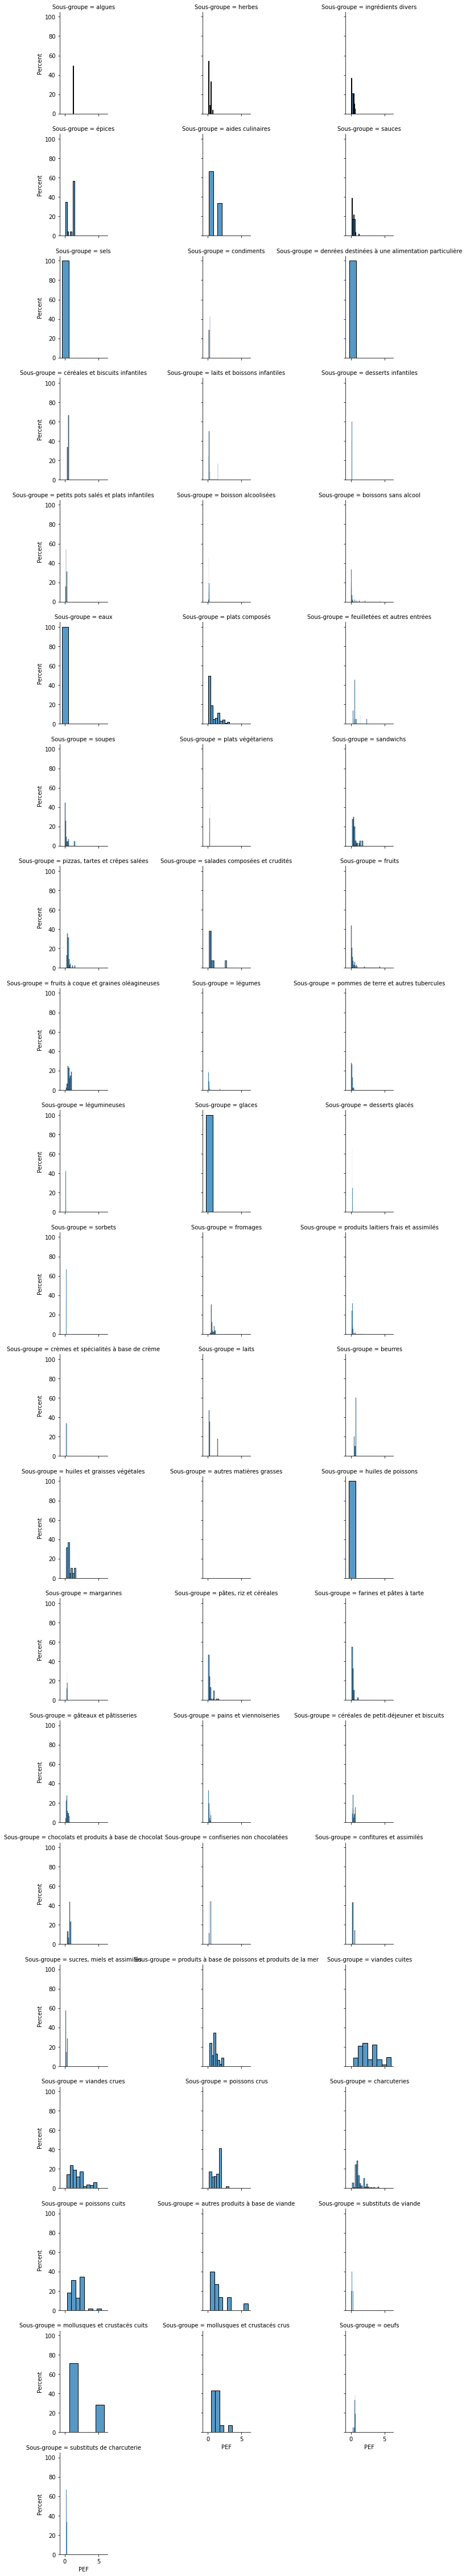

In [45]:
g = sns.FacetGrid(data_AGB, col='Sous-groupe', col_wrap=3)
g.map_dataframe(sns.histplot, x = 'PEF', stat = 'percent')
g.figure.subplots_adjust(wspace=2, hspace=0.2)

In [46]:
data_AGB['Sous-groupe'].unique()

array(['algues', 'herbes', 'ingrédients divers', 'épices',
       'aides culinaires', 'sauces', 'sels', 'condiments',
       'denrées destinées à une alimentation particulière',
       'céréales et biscuits infantiles', 'laits et boissons infantiles',
       'desserts infantiles', 'petits pots salés et plats infantiles',
       'boisson alcoolisées', 'boissons sans alcool', 'eaux',
       'plats composés', 'feuilletées et autres entrées', 'soupes',
       'plats végétariens', 'sandwichs',
       'pizzas, tartes et crêpes salées', 'salades composées et crudités',
       'fruits', 'fruits à coque et graines oléagineuses', 'légumes',
       'pommes de terre et autres tubercules', 'légumineuses', 'glaces',
       'desserts glacés', 'sorbets', 'fromages',
       'produits laitiers frais et assimilés',
       'crèmes et spécialités à base de crème', 'laits', 'beurres',
       'huiles et graisses végétales', 'autres matières grasses',
       'huiles de poissons', 'margarines', 'pâtes, riz et 

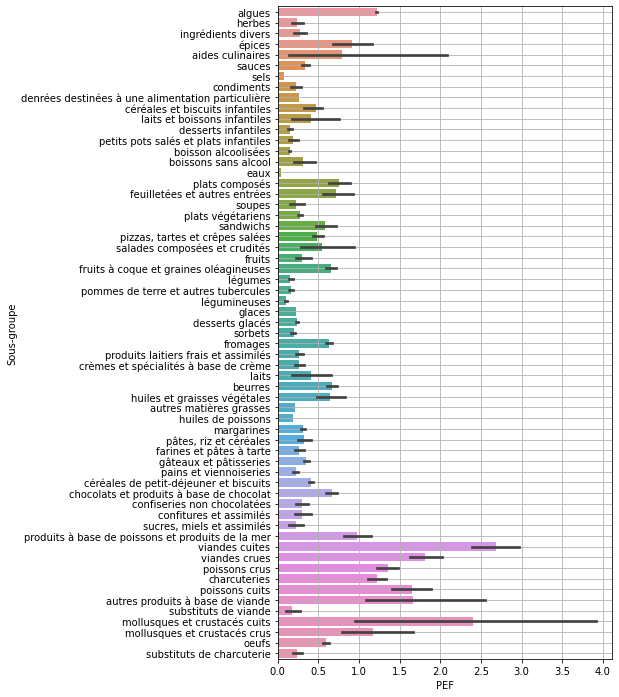

In [47]:
plt.figure(figsize=(6,12))
ax = sns.barplot(data = data_AGB, y = 'Sous-groupe', x = 'PEF', orient = 'h')
plt.grid()

**Let's associate each unmatchable JOW ingredient to its Agribalyse category and compute the mean scores for each category**  
Let's start by calculating the mean scores of all categories

In [48]:
# Keep only relevant columns
data_category_AGB = data_AGB[['Sous-groupe']+score_col_names]
# Calculate the mean scores for all categories
data_category_AGB = data_category_AGB.groupby('Sous-groupe').mean().reset_index()
# Rename columns
data_category_AGB.columns = ['Sous-groupe'] + new_score_col_names
data_category_AGB.head()

,Sous-groupe,Mean PEF,Mean CO2,Mean Ozone_1,Mean Rad,Mean Ozone_2,Mean Particules,Mean Toxic_1,Mean Toxic_2,Mean Acid,Mean Eutro_1,Mean Eutro_2,Mean Eutro_3,Mean Ecotoxic,Mean Sol,Mean Ressource_1,Mean Ressource_2,Mean Ressource_3
0,aides culinaires,0.790395,3.730273,3.621496e-07,10.500534,0.011454,2.402906e-07,9.872410e-08,3.611237e-09,0.028303,0.001132,0.013857,0.081890,34.457146,100.123185,4.504023,250.561975,0.000024
1,algues,1.218565,6.673668,9.985337e-07,11.044007,0.036903,7.139320e-07,7.399463e-08,6.426002e-09,0.096972,0.001863,0.012596,0.119754,44.192774,26.226826,3.100700,313.844725,0.000087
2,autres matières grasses,0.212641,1.667794,1.169996e-07,0.444802,0.004132,1.770731e-07,2.750681e-08,1.332591e-09,0.023606,0.000294,0.006039,0.098250,26.607597,73.354309,1.291387,21.503246,0.000008
3,autres produits à base de viande,1.667115,14.760065,6.470614e-07,2.008331,0.027231,1.527797e-06,2.766280e-07,9.292739e-09,0.219602,0.001569,0.057666,0.951504,130.510969,1080.888494,6.716643,89.512487,0.000038
4,beurres,0.674535,6.960263,2.122798e-07,0.826577,0.011826,5.142695e-07,1.609791e-07,4.413134e-09,0.074741,0.000767,0.024032,0.321946,75.314653,400.480065,2.227935,33.777776,0.000022


Identify the unmatchable jow ingredients

In [51]:
unmatchable_jow_ings = df[df['AGB ingredients (simple, fr)']=='no match']['JOW ingredients (simple, fr)'].values.tolist()
unmatchable_jow_ings

['Cornichon',
 'Chapelure',
 'Ricotta',
 'Burrata',
 'Olive noire',
 'Bouquet garni',
 'Vinaigre de riz',
 'Câpres',
 'Tabasco',
 'Pâte de curry',
 'Fond de veau',
 'Feuille de riz',
 "Arôme fleur d'oranger",
 'Chili',
 'Huile aromatisée à la truffe',
 'Wasabi',
 'Mascarpone',
 'Yaourt végétal',
 'Coquillettes, courgettes, tomates, thym',
 'Mélange curry de lentilles',
 'Os à moelle',
 'Baies roses',
 'Tzatziki',
 'Anis étoilé',
 'Vol-au-vent',
 'Toast',
 'Granola']

We find by hand the corresponding agribalyse categories

In [52]:
agb_jow_dict = {
    'Cornichon': 'condiments',
    'Chapelure': 'pains et viennoiseries',
    'Ricotta': 'fromages',
    'Burrata': 'fromages',
    'Olive noire': 'condiments',
    'Bouquet garni': 'herbes',
    'Vinaigre de riz': 'condiments',
    'Câpres': 'condiments',
    'Tabasco': 'condiments',
    'Pâte de curry': 'condiments',
    'Fond de veau': 'aides culinaires',
    'Feuille de riz': 'aides culinaires',
    "Arôme fleur d'oranger": 'aides culinaires',
    'Chili': 'épices',
    'Huile aromatisée à la truffe': 'huiles et graisses végétales',
    'Wasabi': 'condiments',
    'Mascarpone': 'fromages',
    'Yaourt végétal': 'plats végétariens',
    'Coquillettes, courgettes, tomates, thym': 'plats végétariens',
    'Mélange curry de lentilles': 'légumineuses',
    'Os à moelle': 'viandes cuites',
    'Baies roses': 'fruits',
    'Tzatziki': 'plats végétariens',
    'Anis étoilé': 'épices',
    'Vol-au-vent': 'farines et pâtes à tarte',
    'Toast': 'pains et viennoiseries',
    'Granola': 'céréales de petit-déjeuner et biscuits'
}

Fill in the dataframe

In [53]:
for jow_ingredient, agb_category in agb_jow_dict.items():
    df.loc[df['JOW ingredients (simple, fr)']==jow_ingredient, new_score_col_names] = data_category_AGB.loc[data_category_AGB['Sous-groupe']==agb_category, new_score_col_names].values

Save data

In [55]:
df.to_excel("Jow_Agribalyse_ingredients_scores.xlsx")

df['AGB ingredients (simple, fr)'] = df['AGB ingredients (simple, fr)'].apply(change_type)
df.to_json("Jow_Agribalyse_ingredients_scores.json")